## **Initial Setup: Google Drive Mount**

This cell sets up access to Google Drive where the dataset is stored.

- **`from google.colab import drive`**: Imports the Google Colab drive module for mounting Google Drive
- **`drive.mount('/content/drive')`**: Mounts your Google Drive to the `/content/drive` directory, allowing the notebook to access files stored in Drive
- **`import pandas as pd`**: Imports pandas, which we'll use for data manipulation throughout this notebook

After running this cell, you'll need to authenticate with Google to grant access to your Drive. This is a one-time setup step in Google Colab.


In [1]:
#import and mount drive
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **Step 2: Data Exploration**

This cell explores the unique values in key categorical columns to understand the data distribution:

- **`Data['roles'].unique()`**: Shows all unique role combinations (e.g., ["CEO"], ["CEO", "CTO"]) - founders can have multiple roles
- **`Data['preferred_role'].unique()`**: Shows the single preferred role for each founder (CEO, CTO, COO, CPO)
- **`Data['industry'].unique()`**: Displays all industries represented in the dataset (Fintech, Healthtech, SaaS, etc.)
- **`Data['secondary_industries'].unique()`**: Shows secondary industries (most are empty, some have values like ["Fintech"])

This exploration helps us understand:
1. The structure of multi-label columns (like `roles`) vs single-label columns (like `preferred_role`)
2. The diversity of industries and roles in the dataset
3. What preprocessing steps will be needed (e.g., parsing JSON-like strings for multi-label columns)


In [2]:
Data=pd.read_csv('/content/drive/MyDrive/INDENG 242A/founders_dataset.csv')
display(pd.DataFrame(Data.columns))


,0
0,roles
1,preferred_role
2,industry
3,secondary_industries
4,years_of_experience
5,is_technical
6,education_level
7,tech_stack
8,strengths
9,weaknesses


In [3]:
#Data[Data['secondary_industries']!='[]']

print(Data['roles'].unique())
print(Data['preferred_role'].unique())
print(Data['industry'].unique())
print(Data['secondary_industries'].unique())

['["COO"]' '["CEO"]' '["CTO"]' '["CPO"]' '["CEO", "CPO"]' '["CEO", "CTO"]'
 '["COO", "CPO"]' '["CEO", "COO"]' '["COO", "CTO"]' '["CPO", "COO"]'
 '["CTO", "COO"]' '["CTO", "CPO"]' '["CPO", "CEO"]' '["CPO", "CTO"]']
['COO' 'CEO' 'CTO' 'CPO']
['Other' 'Gaming / Entertainment' 'Consumer / Social' 'Fintech'
 'Marketplaces' 'Climate / Greentech' 'Edtech' 'E-commerce'
 'AI / Deeptech' 'Healthtech' 'Web3 / Crypto' 'Biotech' 'SaaS']
['[]' '["Fintech"]']


## **Step 3: Library Imports for Machine Learning**

This cell imports essential libraries for the collaborative filtering implementation:

- **`ast`**: Used to safely parse string representations of Python lists (e.g., converting `'["CEO", "CTO"]'` to actual list `["CEO", "CTO"]`)
- **`numpy`**: Provides numerical computing capabilities and array operations
- **`pandas`**: Data manipulation and analysis
- **`MultiLabelBinarizer`**: Encodes multi-label categorical data (where one sample can belong to multiple categories) into binary feature vectors
- **`StandardScaler`**: Standardizes features by removing the mean and scaling to unit variance (important for numerical features with different scales)
- **`normalize`**: L2-normalizes vectors to unit length (necessary for cosine similarity calculations)
- **`cosine_similarity`**: Computes cosine similarity between vectors (measures angle between vectors, useful for measuring similarity)
- **`train_test_split`**: Splits data into training, validation, and test sets for model evaluation


In [4]:
import ast
import numpy as np
import pandas as pd

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split


### **Step 3.1: Data Overview**

This cell provides a quick overview of the dataset:

- **`df = Data`**: Assigns the loaded data to a simpler variable name `df` for easier reference
- **`df.shape`**: Returns a tuple (rows, columns) showing the dimensions of the dataset
  - Output: `(1209, 25)` means we have 1209 founders and 25 features/columns
- **`df.head()`**: Displays the first 5 rows of the DataFrame, giving us a preview of the data structure and values

This helps verify that the data loaded correctly and gives us an initial sense of the dataset size and content.


In [5]:
# Path to your file
df = Data
print(df.shape)
df.head()


(1209, 25)


,roles,preferred_role,industry,secondary_industries,years_of_experience,is_technical,education_level,tech_stack,strengths,weaknesses,...,gender,collaboration_openness_score,communication_intensity_score,responsiveness_score,risk_tolerance,leadership,autonomy,vision,communication,execution_speed
0,"[""COO""]",COO,Other,[],4,False,bachelor,"[""Swift"", ""Node.js""]","[""User empathy"", ""Communication skills"", ""Anal...","[""Risk-averse"", ""Impatient with slow processes""]",...,M,0.036290,0.024107,0.143475,2,2,3,3,3,4
1,"[""CEO""]",CEO,Gaming / Entertainment,[],7,True,self-taught,"[""Unity"", ""C#"", ""JavaScript"", ""Webflow""]","[""User empathy"", ""Team-building"", ""Creativity ...","[""Poor work-life balance"", ""Limited business e...",...,M,0.031654,0.010418,0.177019,4,2,3,4,5,5
2,"[""CEO""]",CEO,Consumer / Social,[],3,False,bachelor,"[""React"", ""Node.js"", ""Firebase""]","[""Creativity and vision"", ""High ownership"", ""P...","[""Overly detail-oriented"", ""Weak in sales""]",...,M,0.022029,0.003984,0.092243,4,5,4,3,5,3
3,"[""COO""]",COO,Fintech,[],12,False,master,"[""Figma"", ""Swift"", ""Notion"", ""AWS""]","[""High ownership"", ""Resilience"", ""Fast executi...","[""Overly optimistic"", ""Easily distracted by ne...",...,M,0.277378,0.036848,0.127754,4,2,2,4,4,5
4,"[""CTO""]",CTO,Other,[],2,True,bachelor,"[""AWS"", ""Django"", ""Swift"", ""Docker""]","[""Resilience"", ""Scrappiness"", ""Strong leadersh...","[""Overly detail-oriented"", ""Poor work-life bal...",...,M,0.195837,0.125118,0.038137,4,3,3,2,4,3


## **Step 4: Feature Preprocessing Overview**

Before we can compute similarities between founders, we need to convert all their attributes into a numerical feature matrix. This involves:

1. **Multi-label encoding**: Columns like `roles` and `tech_stack` contain lists (e.g., `["CEO", "CTO"]`) that need to be converted to binary feature vectors
2. **One-hot encoding**: Single categorical columns like `industry` and `preferred_role` need to be converted to binary indicators
3. **Numeric scaling**: Numerical features like `years_of_experience` need to be standardized so they're on the same scale
4. **L2 normalization**: Finally, each founder's feature vector is normalized to unit length, which is required for cosine similarity to work properly

The result will be a matrix where each row represents one founder as a vector of numerical features.


### **Step 4.1: Column Classification**

This cell categorizes all columns in the dataset by their data type:

- **`multi_label_cols`**: Columns that contain lists of values (e.g., a founder can have multiple roles, multiple technologies in their tech stack, multiple strengths/weaknesses). These need special handling using MultiLabelBinarizer.

- **`single_cat_cols`**: Columns with single categorical values (e.g., each founder has one preferred role, one industry, one education level). These will be one-hot encoded using `pd.get_dummies()`.

- **`numeric_cols`**: Numerical features that will be standardized (e.g., years of experience, age, various scores). These represent continuous or ordinal data.

- **`FOUNDER_ID_COL`**: The identifier column that uniquely identifies each founder.

This classification is crucial because different column types require different preprocessing approaches.


### **Step 4.2: Parsing Multi-Label Columns**

This cell converts string representations of lists into actual Python lists:

- **`df[col].fillna('[]')`**: Replaces missing values with empty list string `'[]'` to avoid errors during parsing
- **`ast.literal_eval()`**: Safely evaluates a string containing a Python literal (like `'["CEO", "CTO"]'`) and converts it to an actual Python list `["CEO", "CTO"]`. This is safer than `eval()` as it only evaluates literals, not arbitrary code.

For example:
- Input: `'["CEO", "CTO"]'` (string)
- Output: `["CEO", "CTO"]` (list)

This transformation is necessary because when CSV files store lists, they're stored as strings, but we need actual list objects for the MultiLabelBinarizer to work.


### **Step 4.3: Multi-Label Binarization**

This cell converts multi-label columns (lists of values) into binary feature vectors:

**How MultiLabelBinarizer works:**
- For each column, it identifies all unique values across all rows
- Each row is converted to a binary vector where 1 indicates the presence of a value, 0 indicates absence
- Example: If a founder has `roles = ["CEO", "CTO"]` and all possible roles are `["CEO", "CTO", "COO", "CPO"]`, the output vector would be `[1, 1, 0, 0]`

**Process for each multi-label column:**
1. **`MultiLabelBinarizer()`**: Creates a new binarizer instance
2. **`mlb.fit_transform(df[col])`**: Fits the binarizer to learn all unique labels, then transforms the list column into a binary matrix
3. **`pd.DataFrame()`**: Converts the binary array into a DataFrame with meaningful column names (e.g., `roles__CEO`, `roles__CTO`)
4. All resulting DataFrames are stored in `multi_dfs` list for later concatenation

This creates binary features for each possible value in each multi-label column, allowing the model to capture which founders share similar roles, skills, or characteristics.


### **Step 4.4-4.6: Combining All Features**

This cell combines all feature types into a single feature matrix:

**Step 4.4: One-Hot Encoding for Single Categorical Columns**
- **`pd.get_dummies()`**: Converts each categorical column into multiple binary columns (one for each category)
  - Example: `industry` with values `["Fintech", "Healthtech"]` becomes two columns: `industry_Fintech` and `industry_Healthtech`
- **`.fillna("Unknown")`**: Handles missing values by replacing them with "Unknown" category
- **`prefix=single_cat_cols`**: Adds prefixes to column names to identify their source (e.g., `industry_Fintech` instead of just `Fintech`)

**Step 4.5: Numeric Feature Preparation**
- Creates a copy of numeric columns
- **`astype(int)`**: Converts boolean column `is_technical` to integer (True→1, False→0) so it can be treated as numeric

**Step 4.6: Final Feature Matrix Assembly**
- **`pd.concat()`**: Concatenates all DataFrames horizontally (axis=1):
  - Numeric features (already scaled)
  - One-hot encoded categorical features
  - Multi-label binarized features
- Result: A single matrix where each row is a founder and each column is a feature (total of 1353 features across 1209 founders)

This unified feature matrix will be used to compute similarities between founders.


### **Step 4.7: Standardization and L2 Normalization**

This cell prepares the feature vectors for cosine similarity calculation:

**Standardization (Z-score normalization):**
- **`StandardScaler()`**: Creates a scaler that will transform features to have mean=0 and std=1
- **`scaler.fit_transform(features.values)`**:
  - **`fit`**: Computes the mean and standard deviation of each feature column from the training data
  - **`transform`**: Applies the transformation: `(x - mean) / std` for each feature
- **Why?**: Different features are on different scales (e.g., age might be 25-65, while scores might be 0-10). Standardization ensures all features contribute equally to similarity calculations.

**L2 Normalization:**
- **`normalize(X_std)`**: Normalizes each row (founder vector) to have unit length (L2 norm = 1)
- This is done by dividing each vector by its magnitude: `v_normalized = v / ||v||`
- **Why?**: Cosine similarity measures the angle between vectors, not their magnitude. Normalizing to unit length ensures we're only comparing directions, not sizes.

After this step, each founder is represented as a unit vector, and cosine similarity between two founders equals their dot product, making similarity computation efficient and interpretable.


Feature preprocessing (one-hot + multi-hot + scaling):

* parse list-like columns (e.g. ["Swift", "Node.js"])

* multi-hot encode them

* one-hot encode single categorical labels

* keep numeric features and scale them

* L2-normalize rows to prepare for cosine similarity

In [6]:
# ---- 4.1: specify columns by type ----
multi_label_cols = [
    'roles',
    'secondary_industries',
    'tech_stack',
    'strengths',
    'weaknesses'
]

single_cat_cols = [
    'preferred_role',
    'industry',
    'education_level',
    'gender'
]

numeric_cols = [
    'years_of_experience',
    'is_technical',
    'age',
    'collaboration_openness_score',
    'communication_intensity_score',
    'responsiveness_score',
    'risk_tolerance',
    'leadership',
    'autonomy',
    'vision',
    'communication',
    'execution_speed'
]

FOUNDER_ID_COL = 'founder_id'


In [7]:
# ---- 4.2: parse multi-label columns (JSON-like strings -> Python lists) ----
for col in multi_label_cols:
    df[col] = df[col].fillna('[]').apply(ast.literal_eval)

df[multi_label_cols].head(2)


,roles,secondary_industries,tech_stack,strengths,weaknesses
0,[COO],[],"[Swift, Node.js]","[User empathy, Communication skills, Analytica...","[Risk-averse, Impatient with slow processes]"
1,[CEO],[],"[Unity, C#, JavaScript, Webflow]","[User empathy, Team-building, Creativity and v...","[Poor work-life balance, Limited business expe..."


In [8]:
# ---- 4.3: MultiLabelBinarizer for list-like columns ----
multi_dfs = []
for col in multi_label_cols:
    mlb = MultiLabelBinarizer()
    arr = mlb.fit_transform(df[col])
    multi_dfs.append(
        pd.DataFrame(
            arr,
            columns=[f"{col}__{c}" for c in mlb.classes_],
            index=df.index
        )
    )

len(multi_dfs), multi_dfs[0].shape


(5, (1209, 4))

In [9]:
# ---- 4.4: One-hot encode single categorical columns ----
single_df = pd.get_dummies(
    df[single_cat_cols].fillna("Unknown"),
    prefix=single_cat_cols
)

# ---- 4.5: Numeric features (cast bool to int) ----
numeric_df = df[numeric_cols].copy()
if 'is_technical' in numeric_df.columns:
    numeric_df['is_technical'] = numeric_df['is_technical'].astype(int)

# ---- 4.6: Final feature matrix ----
features = pd.concat([numeric_df, single_df] + multi_dfs, axis=1)
print("Feature matrix shape:", features.shape)


Feature matrix shape: (1209, 144)


In [10]:
# ---- 4.7: Standardize & L2-normalize founder vectors ----
scaler = StandardScaler()
X_std = scaler.fit_transform(features.values)

# Normalize each founder vector to unit length for cosine similarity
from sklearn.preprocessing import normalize
X = normalize(X_std)
X.shape


(1209, 144)

## **Step 5: Building the Similarity Matrix**

This cell creates a pairwise similarity matrix between all founders using cosine similarity:

**What is Cosine Similarity?**
- Measures the cosine of the angle between two vectors
- Range: -1 (opposite directions) to 1 (same direction), with 0 meaning perpendicular
- For normalized unit vectors, cosine similarity equals the dot product
- Higher values indicate more similar founders

**Process:**
1. **`cosine_similarity(X)`**: Computes pairwise cosine similarity between all founder vectors
   - Input: Matrix X where each row is a founder's normalized feature vector
   - Output: Matrix R of shape (n_founders × n_founders) where R[i,j] = similarity between founder i and founder j

2. **`np.fill_diagonal(R, 0.0)`**: Sets diagonal elements to 0
   - The diagonal represents self-similarity (founder i compared to founder i), which is always 1.0 but not useful for recommendations
   - Setting to 0 prevents a founder from being recommended to themselves

**Result**: A symmetric similarity matrix R where:
- R[i,j] = similarity score between founder i and founder j
- Higher scores indicate better matches
- We'll treat this as our "ratings" matrix for collaborative filtering


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

R = cosine_similarity(X)      # shape (n_founders, n_founders)
np.fill_diagonal(R, 0.0)      # remove trivial self-similarity

n_founders = R.shape[0]
print("Similarity matrix shape:", R.shape)
print("min/max:", float(R.min()), float(R.max()))


Similarity matrix shape: (1209, 1209)
min/max: -0.32925986429281795 0.9247943366494971


## **Step 6: Creating Training/Validation/Test Split**

This cell prepares the data for machine learning by splitting it into train, validation, and test sets:

**Creating Pairwise Observations:**
- **`~np.eye(n_founders, dtype=bool)`**: Creates a boolean mask that excludes the diagonal
  - `np.eye()` creates an identity matrix (1s on diagonal, 0s elsewhere)
  - The `~` operator negates it, so diagonal becomes False, off-diagonal becomes True
- **`np.where(mask)`**: Returns indices where mask is True (i.e., all pairs where i ≠ j)
- **`user_indices, item_indices`**: In collaborative filtering terms:
  - `user_indices` = founder i (the "user" seeking a co-founder)
  - `item_indices` = founder j (the potential co-founder or "item" to recommend)
- **`ratings = R[user_indices, item_indices]`**: Extracts similarity scores for all pairs

**Why this representation?**
- Each pair (i, j) represents one observation: "How similar is founder i to founder j?"
- This format matches what matrix factorization models expect: (user_id, item_id, rating) tuples

**Splitting the Data:**
- **80% training**: Used to train the matrix factorization model
- **10% validation**: Used to tune hyperparameters and select the best model
- **10% test**: Used for final evaluation (unseen during training and tuning)

**`train_test_split()`**:
- Randomly splits indices while preserving the relationship between user_indices, item_indices, and ratings
- `random_state=42` ensures reproducible splits

This split allows us to train the model on some data, tune hyperparameters on validation data, and get an unbiased final evaluation on test data.


In [12]:
# mask to exclude diagonal
mask = ~np.eye(n_founders, dtype=bool) # sets the diagonal to False cuz we don't want useri,useri recommendation (perfect match)
user_indices, item_indices = np.where(mask)
ratings = R[user_indices, item_indices]

print("Number of pairwise observations:", len(ratings))


Number of pairwise observations: 1460472


In [13]:
# Train / validation / test split on pair indices
idx_all = np.arange(len(ratings)) #get an index for each user

# 20% test
train_idx, test_idx = train_test_split(
    idx_all, test_size=0.2, random_state=42
)
# 10% of remaining as validation
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.1, random_state=42
)

u_train = user_indices[train_idx]
i_train = item_indices[train_idx]
r_train = ratings[train_idx]

u_val   = user_indices[val_idx]
i_val   = item_indices[val_idx]
r_val   = ratings[val_idx]

u_test  = user_indices[test_idx]
i_test  = item_indices[test_idx]
r_test  = ratings[test_idx]

len(train_idx), len(val_idx), len(test_idx)


(1051539, 116838, 292095)

## **Step 7: Matrix Factorization Model Definition**

This cell defines the `MatrixFactorization` class, which implements collaborative filtering using matrix factorization.

**What is Matrix Factorization?**
Matrix factorization decomposes the user-item rating matrix R (n_founders × n_founders) into two lower-dimensional matrices:
- **P** (n_founders × A): User/founder latent factors (embeddings)
- **Q** (n_founders × A): Item/founder latent factors (embeddings)

Where A is the number of latent factors (archetypes).

**Prediction Formula:**
```
rating_ij ≈ μ + b_u[i] + b_i[j] + P[i] · Q[j]
```

**Components:**
1. **μ (mu)**: Global bias (average rating across all pairs)
2. **b_u[i]**: User bias (how much founder i tends to rate others higher/lower than average)
3. **b_i[j]**: Item bias (how much founder j tends to be rated higher/lower than average)
4. **P[i] · Q[j]**: Dot product of latent factor vectors (captures interaction between founder i and founder j's characteristics)

**Key Methods:**

**`__init__()`**: Initializes hyperparameters
- `n_factors`: Number of latent dimensions (archetypes) - controls model complexity
- `lr`: Learning rate for gradient descent updates
- `reg`: Regularization strength (prevents overfitting by penalizing large parameter values)
- `n_epochs`: Number of training iterations over the dataset

**`fit()`**: Trains the model using stochastic gradient descent
- Initializes P, Q, b_u, b_i with small random values
- For each epoch, randomly permutes training examples
- For each (user, item, rating) triple:
  - Computes prediction and error
  - Updates parameters using gradient descent with regularization
- Tracks validation RMSE and keeps best parameters (early stopping)

**`predict_single()`**: Predicts similarity score for a single (founder i, founder j) pair

**`rmse()`**: Computes Root Mean Square Error for evaluation

This model learns to represent founders in a low-dimensional space where similar founders are close together, enabling effective recommendations.


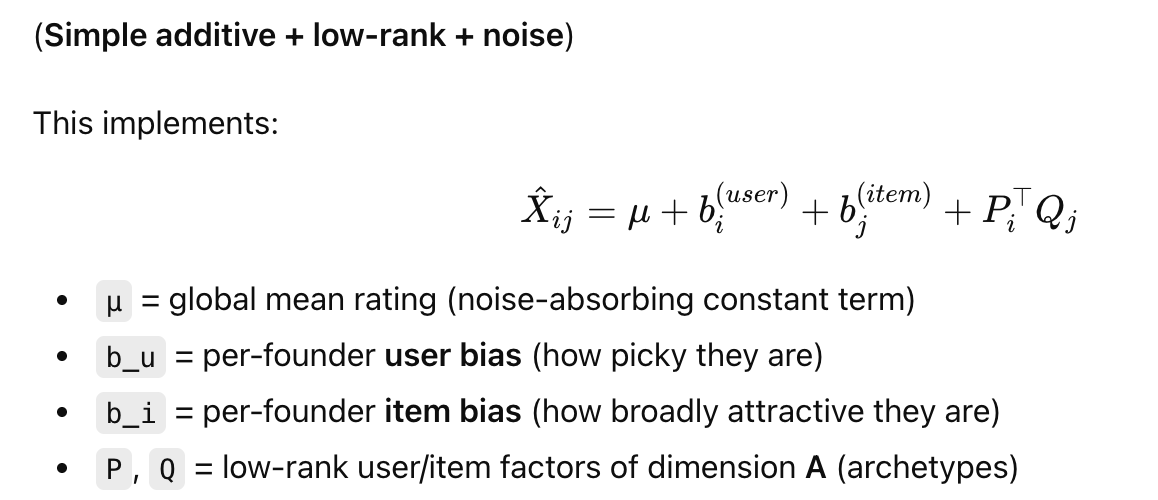

In [14]:
class MatrixFactorization:
    """
    Standard explicit-feedback matrix factorization with user/item biases:
    rating_ij ~ mu + b_u[i] + b_i[j] + P[i]·Q[j]

    This corresponds to:
        Simple Additive (mu + b_u + b_i) + Low-Rank (P Q^T) + Noise
    """
    def __init__(self, n_users, n_items, n_factors=20,
                 lr=0.01, reg=0.02, n_epochs=10, verbose=True,
                 random_state=42):
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg
        self.n_epochs = n_epochs
        self.verbose = verbose
        self.random_state = random_state

    def fit(self, user_idx, item_idx, ratings,
            val_user_idx=None, val_item_idx=None, val_ratings=None):
        rng = np.random.default_rng(self.random_state)
        n_obs = len(ratings)

        # Initialize parameters
        self.P = 0.1 * rng.standard_normal((self.n_users, self.n_factors))
        self.Q = 0.1 * rng.standard_normal((self.n_items, self.n_factors))
        self.b_u = np.zeros(self.n_users)
        self.b_i = np.zeros(self.n_items)
        self.mu = ratings.mean()

        best_val_rmse = np.inf
        best_params = None

        for epoch in range(self.n_epochs):
            perm = rng.permutation(n_obs)
            for idx in perm:
                u = user_idx[idx]
                i = item_idx[idx]
                r = ratings[idx]

                # prediction and error
                pred = self.mu + self.b_u[u] + self.b_i[i] + np.dot(self.P[u], self.Q[i])
                err = r - pred

                # gradient updates
                self.b_u[u] += self.lr * (err - self.reg * self.b_u[u])
                self.b_i[i] += self.lr * (err - self.reg * self.b_i[i])

                Pu = self.P[u].copy()
                Qi = self.Q[i].copy()

                self.P[u] += self.lr * (err * Qi - self.reg * Pu)
                self.Q[i] += self.lr * (err * Pu - self.reg * Qi)

            # metrics
            train_rmse = self.rmse(user_idx, item_idx, ratings)
            if val_ratings is not None:
                val_rmse = self.rmse(val_user_idx, val_item_idx, val_ratings)
                if self.verbose:
                    print(f"Epoch {epoch+1}/{self.n_epochs} "
                          f"train_rmse={train_rmse:.4f}  val_rmse={val_rmse:.4f}")
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    best_params = (
                        self.P.copy(), self.Q.copy(),
                        self.b_u.copy(), self.b_i.copy(), self.mu
                    )
            else:
                if self.verbose:
                    print(f"Epoch {epoch+1}/{self.n_epochs} train_rmse={train_rmse:.4f}")

        # restore best validation parameters
        if val_ratings is not None and best_params is not None:
            self.P, self.Q, self.b_u, self.b_i, self.mu = best_params

        return self

    def predict_single(self, u, i):
        return self.mu + self.b_u[u] + self.b_i[i] + np.dot(self.P[u], self.Q[i])

    def rmse(self, u_idx, i_idx, ratings):
        preds = self.mu + self.b_u[u_idx] + self.b_i[i_idx] + \
                np.sum(self.P[u_idx] * self.Q[i_idx], axis=1)
        return np.sqrt(np.mean((ratings - preds) ** 2))


## **Step 8: Hyperparameter Tuning**

This cell performs hyperparameter tuning to find the optimal number of latent factors (archetypes):

**What are Latent Factors?**
- Latent factors (A) represent hidden dimensions in founder characteristics
- Think of them as "archetypes" or underlying traits that describe founders
- More factors can capture more complexity but may overfit
- Fewer factors are simpler but may miss important patterns

**Tuning Process:**
1. **`latent_dims = [4, 8, 12, 16, 24]`**: Tests different numbers of latent factors
2. For each value of A:
   - Creates a new `MatrixFactorization` model with A factors
   - Trains on training data
   - Evaluates on validation data (used for model selection)
   - Also evaluates on test data (for reporting, but not used for selection)
3. **Best model selection**: Chooses the model with lowest validation RMSE

**Why Validation RMSE?**
- Validation set is held out during training
- Lower validation RMSE indicates better generalization
- We don't use test RMSE for selection to keep test set truly independent

**Model Parameters:**
- `lr=0.01`: Learning rate (step size for gradient updates)
- `reg=0.02`: Regularization strength (prevents overfitting)
- `n_epochs=10`: Number of training iterations

The best model will be used for final recommendations. The output shows training progress (RMSE decreasing over epochs) and final validation/test performance for each A value.


In [15]:
latent_dims = [4, 8, 12, 16, 24]
results = []

best_model = None
best_rmse = np.inf
best_A = None

for A in latent_dims:
    print(f"\nTraining model with A = {A} latent factors (archetypes)")
    mf = MatrixFactorization(
        n_users=n_founders,
        n_items=n_founders,
        n_factors=A,
        lr=0.01,
        reg=0.02,
        n_epochs=10,      # increase for better convergence
        verbose=True,
        random_state=42
    )
    mf.fit(u_train, i_train, r_train, u_val, i_val, r_val)
    val_rmse = mf.rmse(u_val, i_val, r_val)
    test_rmse = mf.rmse(u_test, i_test, r_test)

    results.append((A, val_rmse, test_rmse))
    print(f"Finished A={A}:  val_rmse={val_rmse:.4f}, test_rmse={test_rmse:.44f}")

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model = mf
        best_A = A

print("\nSummary (A, val_rmse, test_rmse):")
for row in results:
    print(row)

print(f"\nBest A = {best_A} with val_rmse={best_rmse:.4f}")



Training model with A = 4 latent factors (archetypes)
Epoch 1/10 train_rmse=0.1150  val_rmse=0.1155
Epoch 2/10 train_rmse=0.1146  val_rmse=0.1152
Epoch 3/10 train_rmse=0.1144  val_rmse=0.1150
Epoch 4/10 train_rmse=0.1143  val_rmse=0.1149
Epoch 5/10 train_rmse=0.1143  val_rmse=0.1149
Epoch 6/10 train_rmse=0.1143  val_rmse=0.1149
Epoch 7/10 train_rmse=0.1143  val_rmse=0.1148
Epoch 8/10 train_rmse=0.1143  val_rmse=0.1148
Epoch 9/10 train_rmse=0.1143  val_rmse=0.1147
Epoch 10/10 train_rmse=0.1143  val_rmse=0.1148
Finished A=4:  val_rmse=0.1147, test_rmse=0.11401090600681022813045473185411537997424603

Training model with A = 8 latent factors (archetypes)
Epoch 1/10 train_rmse=0.1156  val_rmse=0.1162
Epoch 2/10 train_rmse=0.1148  val_rmse=0.1155
Epoch 3/10 train_rmse=0.1145  val_rmse=0.1151
Epoch 4/10 train_rmse=0.1143  val_rmse=0.1149
Epoch 5/10 train_rmse=0.1143  val_rmse=0.1149
Epoch 6/10 train_rmse=0.1142  val_rmse=0.1148
Epoch 7/10 train_rmse=0.1142  val_rmse=0.1148
Epoch 8/10 train_r

## **Step 8.1: Visualizing RMSE vs K (Number of Archetypes) Tradeoff**

This visualization shows the relationship between the number of latent factors (archetypes) and model performance:

- **X-axis**: Number of archetypes (k values: 4, 8, 12, 16, 24)
- **Y-axis**: RMSE (Root Mean Squared Error)
- **Two lines**: Validation RMSE and Test RMSE

This helps us understand:
1. **Bias-Variance Tradeoff**: Fewer archetypes may underfit (high bias), while more archetypes may overfit (high variance)
2. **Optimal K**: The point where validation RMSE is minimized indicates the best number of archetypes
3. **Generalization**: The gap between validation and test RMSE indicates how well the model generalizes

The plot helps identify the sweet spot where we have enough complexity to capture patterns without overfitting.


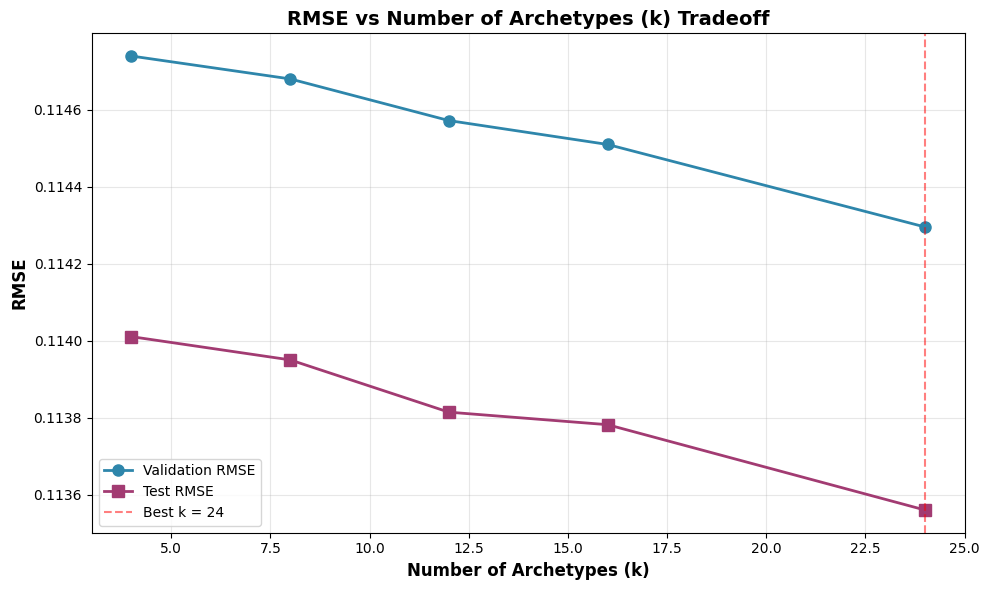


Best model: k = 24 with validation RMSE = 0.1143


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract results for plotting
k_values = [r[0] for r in results]
val_rmses = [r[1] for r in results]
test_rmses = [r[2] for r in results]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, val_rmses, marker='o', linewidth=2, markersize=8, label='Validation RMSE', color='#2E86AB')
plt.plot(k_values, test_rmses, marker='s', linewidth=2, markersize=8, label='Test RMSE', color='#A23B72')

# Highlight the best k
best_k_idx = k_values.index(best_A)
plt.axvline(x=best_A, color='red', linestyle='--', alpha=0.5, label=f'Best k = {best_A}')

plt.xlabel('Number of Archetypes (k)', fontsize=12, fontweight='bold')
plt.ylabel('RMSE', fontsize=12, fontweight='bold')
plt.title('RMSE vs Number of Archetypes (k) Tradeoff', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest model: k = {best_A} with validation RMSE = {best_rmse:.4f}")


## **Step 9: Recommendation Function**

This cell defines a function to generate top-k co-founder recommendations for any given founder:

**`recommend_top_k_for_founder()` Function:**

**Parameters:**
- `model`: The trained MatrixFactorization model
- `founder_index`: The index (0 to n_founders-1) of the founder seeking recommendations
- `k`: Number of top recommendations to return (default: 3)

**Process:**
1. **Generate predictions**: For the given founder, predicts similarity scores with all other founders
   - Uses list comprehension with `model.predict_single(founder_index, j)` for all j
   - Creates array of predicted match scores

2. **Exclude self**: Sets `scores[founder_index] = -np.inf` so the founder won't be recommended to themselves

3. **Select top-k**:
   - `np.argsort(scores)[::-1]`: Gets indices sorted by score in descending order
   - `[:k]`: Takes top k indices

4. **Format results**: Creates a DataFrame with:
   - Founder ID
   - Preferred role
   - Industry
   - Years of experience
   - Technical background (is_technical)
   - Problem space
   - Predicted match score

**Why this approach?**
- Uses the trained model to predict compatibility scores
- Ranks all potential co-founders and returns the most compatible ones
- Provides interpretable output with relevant founder information

This function enables generating personalized recommendations for any founder in the dataset.


In [17]:
founder_ids = df[FOUNDER_ID_COL].tolist()

def recommend_top_k_for_founder(model, founder_index, k=3):
    """
    founder_index: integer index into df (0 .. n_founders-1)
    k: number of recommended cofounders
    """
    n = model.n_users
    scores = np.array([model.predict_single(founder_index, j) for j in range(n)])
    # Do not recommend yourself
    scores[founder_index] = -np.inf

    top_idx = np.argsort(scores)[::-1][:k]
    top_scores = scores[top_idx]

    recs = df.loc[top_idx, [
        FOUNDER_ID_COL,
        'preferred_role',
        'industry',
        'years_of_experience',
        'is_technical',
        'problem_space'
    ]].copy()
    recs['predicted_match_score'] = top_scores

    return recs.reset_index(drop=True)


## **Step 10: Generating Recommendations for All Founders**

This cell generates and stores recommendations for every founder in the dataset:

**Process:**
1. **`founder_ids = df[FOUNDER_ID_COL].tolist()`**: Extracts list of all founder IDs from the dataset

2. **Loop through all founders**: For each founder (indexed 0 to n_founders-1):
   - Calls `recommend_top_k_for_founder()` with the best trained model
   - Requests top 5 recommendations (k=5)
   - Stores results in a dictionary keyed by founder ID

3. **Storage**: `all_recommendations` dictionary maps:
   - Key: founder_id (unique identifier)
   - Value: DataFrame with top 5 recommended co-founders and their details

**Example Usage:**
- After running this cell, you can access recommendations for any founder
- Example: `all_recommendations[some_id]` shows the top 5 co-founder matches for that founder

**Use Cases:**
- Generate comprehensive recommendation sets for all founders
- Enable quick lookup of recommendations by founder ID
- Support batch processing or API endpoints for a recommendation system

This completes the collaborative filtering pipeline: from raw data → feature engineering → similarity computation → matrix factorization → personalized recommendations!


Build observed pairs & train/val/test split

We treat each ordered pair (i, j), i ≠ j, as an “observation” of a rating.

## **Step 11: Archetype Interpretation**

This section analyzes the learned archetypes to understand what characteristics they represent. By examining the average weights of each archetype across different feature categories (industry, preferred_role, tech_stack), we can interpret what each archetype captures.

**How to interpret the heatmaps:**
- Each row represents an archetype (latent factor)
- Each column represents a category value (e.g., "Fintech" industry, "CEO" role)
- The color intensity shows the average weight: darker colors indicate stronger association
- If all users with industry="Fintech" have high weights for Archetype 1, then Archetype 1 is related to Fintech

This analysis helps us understand:
1. What each archetype represents in terms of founder characteristics
2. Which industries, roles, or tech stacks are associated with each archetype
3. How the collaborative filtering model groups similar founders


In [18]:
# Extract archetype weights (Q matrix represents item factors - how each founder relates to each archetype)
# Since users and items are both founders, we can use either P or Q. Using Q for interpretation.
archetype_weights = best_model.Q  # Shape: (n_founders, n_archetypes)

# Create a DataFrame with founder information and archetype weights
founder_archetype_df = df[[FOUNDER_ID_COL, 'industry', 'preferred_role', 'tech_stack']].copy()

# Add archetype weight columns
for arch_idx in range(best_A):
    founder_archetype_df[f'Archetype_{arch_idx+1}'] = archetype_weights[:, arch_idx]

print(f"Archetype weights matrix shape: {archetype_weights.shape}")
print(f"Number of archetypes: {best_A}")
print(f"\nFirst few rows of founder-archetype data:")
founder_archetype_df.head()


Archetype weights matrix shape: (1209, 24)
Number of archetypes: 24

First few rows of founder-archetype data:


,founder_id,industry,preferred_role,tech_stack,Archetype_1,Archetype_2,Archetype_3,Archetype_4,Archetype_5,Archetype_6,...,Archetype_15,Archetype_16,Archetype_17,Archetype_18,Archetype_19,Archetype_20,Archetype_21,Archetype_22,Archetype_23,Archetype_24
0,0a5e3dd8489fe67485ddb7d6adb26ebd,Other,COO,"[Swift, Node.js]",-0.013371,-0.004625,-0.022934,-0.028809,0.001797,0.004661,...,-0.016046,-0.008495,0.000708,-0.000758,0.024973,0.010868,-0.007173,-0.007551,-0.011112,0.010016
1,10a8c197447a3991d64136b315d6e87e,Gaming / Entertainment,CEO,"[Unity, C#, JavaScript, Webflow]",-0.002345,-0.011698,-0.003594,-0.021644,0.005780,-0.018871,...,0.045988,-0.007251,0.043080,0.000725,0.017124,-0.003880,-0.005949,-0.017113,0.012539,0.012023
2,048dd37565ad9cbc24c163ffedffbf58,Consumer / Social,CEO,"[React, Node.js, Firebase]",-0.002921,-0.000063,-0.001581,0.003950,-0.017840,0.011487,...,0.008885,-0.042878,0.013639,-0.012227,-0.000101,0.020126,0.010610,0.018289,-0.030579,0.020781
3,024610702baf540af5637873cd1534e9,Fintech,COO,"[Figma, Swift, Notion, AWS]",-0.007683,0.036187,-0.015666,-0.028104,-0.014682,-0.002109,...,0.012421,0.006470,0.025260,0.027805,0.014979,0.009744,0.020435,-0.025860,-0.005137,0.025983
4,2057ea510896a025db5790675c90b7d6,Other,CTO,"[AWS, Django, Swift, Docker]",0.012667,-0.003650,0.017023,-0.002912,0.023707,-0.002120,...,-0.032149,-0.003707,-0.012066,-0.002839,-0.010691,-0.000807,-0.007256,0.022647,0.001816,-0.011471


### **Step 11.1: Archetype Weights by Industry**

This heatmap shows the average weight of each archetype for founders in different industries. This helps identify which archetypes are associated with specific industries.


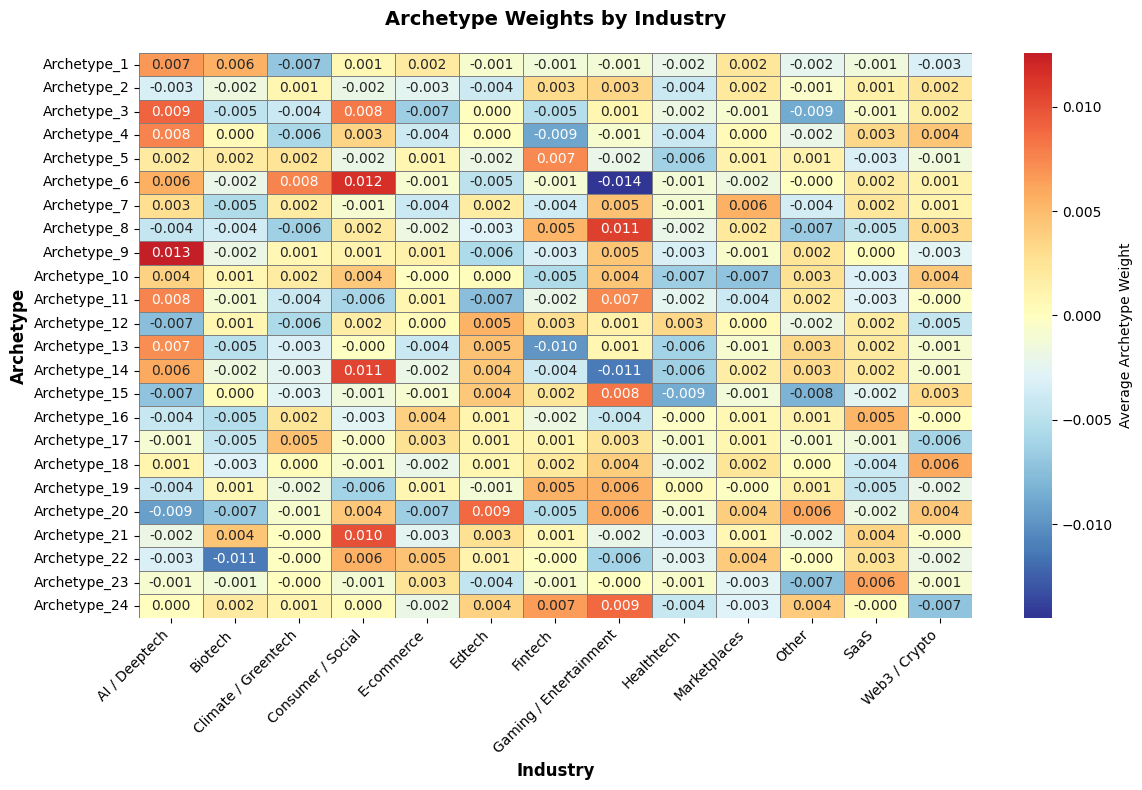

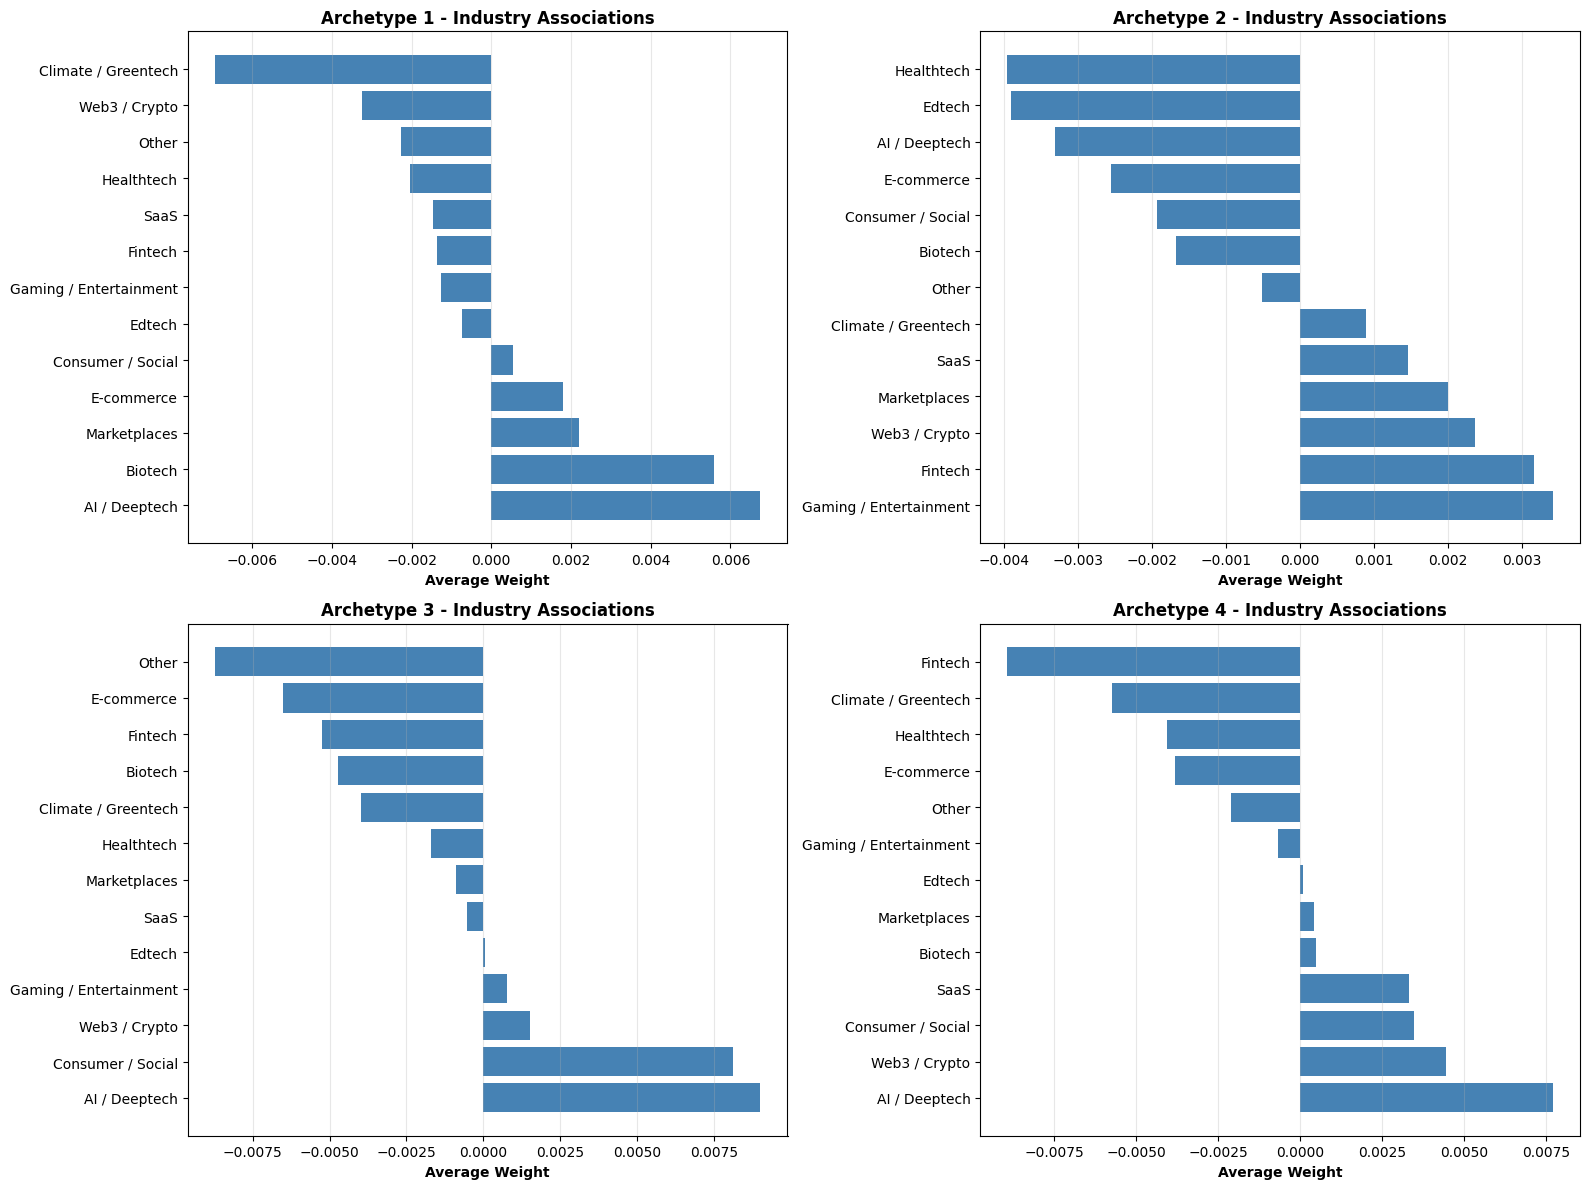

In [19]:
# Calculate average archetype weights by industry
industry_archetype = founder_archetype_df.groupby('industry')[[f'Archetype_{i+1}' for i in range(best_A)]].mean()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(industry_archetype.T,
            annot=True,
            fmt='.3f',
            cmap='RdYlBu_r',
            center=0,
            cbar_kws={'label': 'Average Archetype Weight'},
            linewidths=0.5,
            linecolor='gray')

plt.title('Archetype Weights by Industry', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Industry', fontsize=12, fontweight='bold')
plt.ylabel('Archetype', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Also create a bar plot for better visualization of top associations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for arch_idx in range(min(best_A, 4)):  # Show first 4 archetypes
    arch_data = industry_archetype[f'Archetype_{arch_idx+1}'].sort_values(ascending=False)
    axes[arch_idx].barh(range(len(arch_data)), arch_data.values, color='steelblue')
    axes[arch_idx].set_yticks(range(len(arch_data)))
    axes[arch_idx].set_yticklabels(arch_data.index)
    axes[arch_idx].set_xlabel('Average Weight', fontweight='bold')
    axes[arch_idx].set_title(f'Archetype {arch_idx+1} - Industry Associations', fontweight='bold')
    axes[arch_idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


### **Step 11.2: Archetype Weights by Preferred Role**

This heatmap shows the average weight of each archetype for founders with different preferred roles (CEO, CTO, COO, CPO).


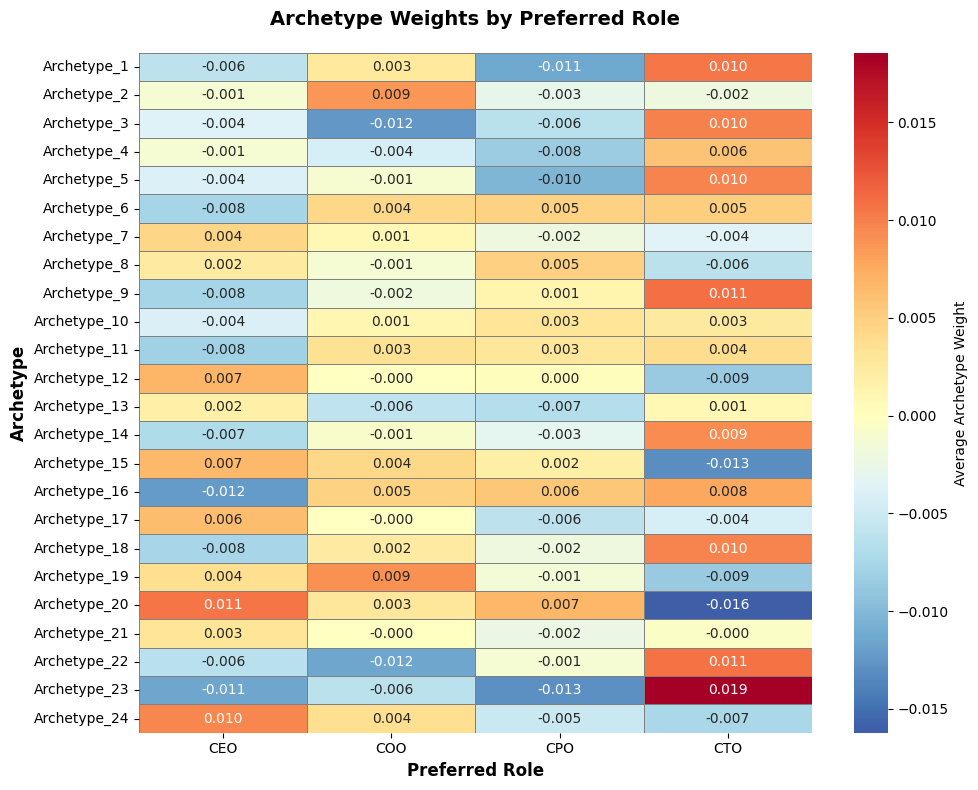

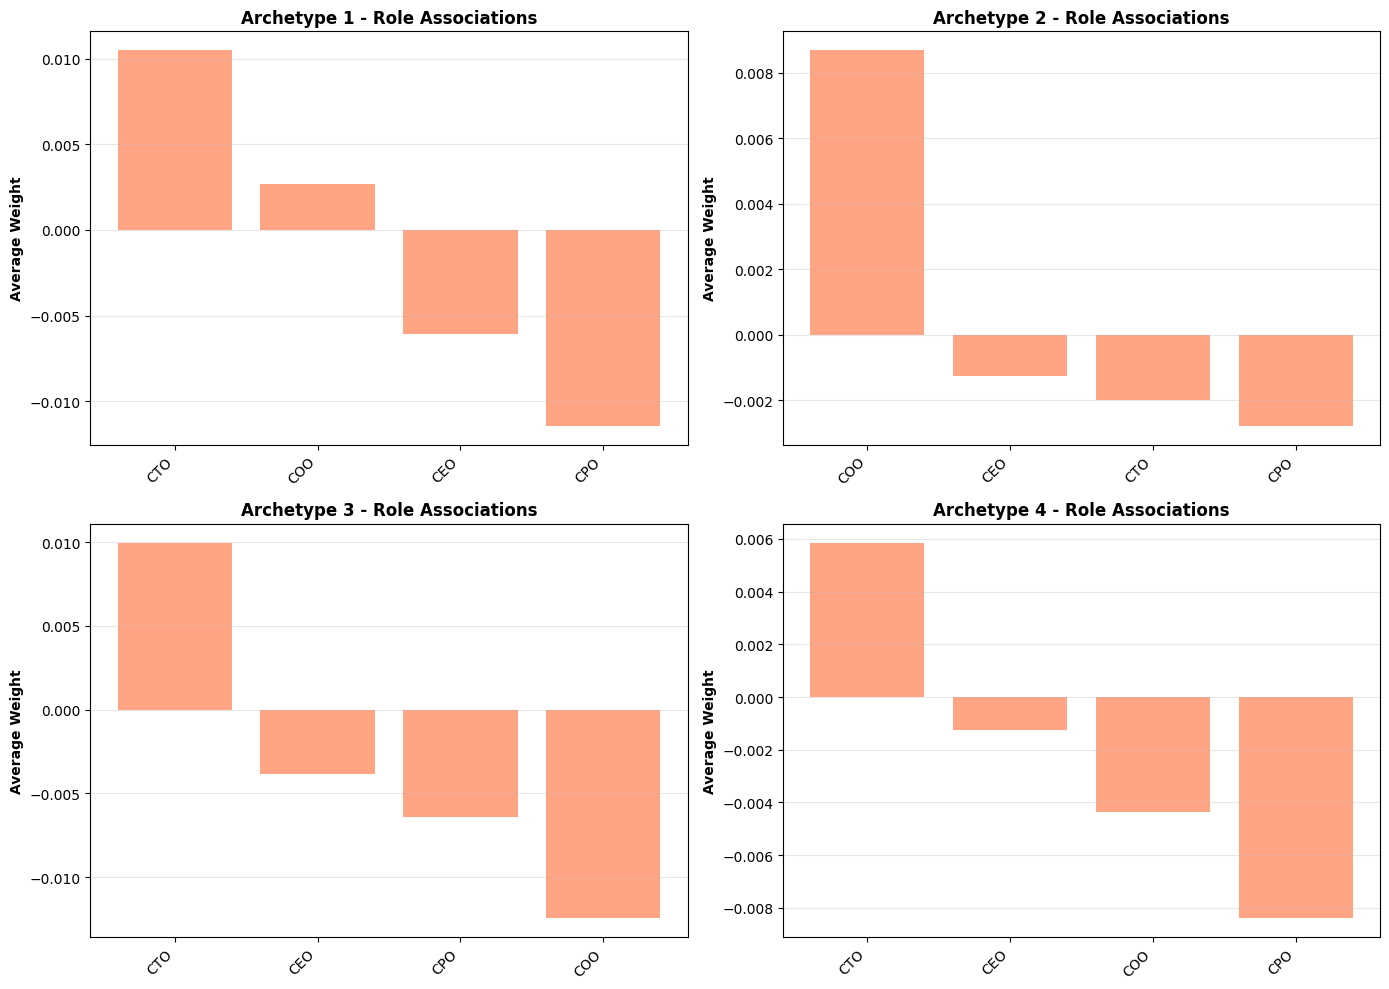

In [20]:
# Calculate average archetype weights by preferred_role
role_archetype = founder_archetype_df.groupby('preferred_role')[[f'Archetype_{i+1}' for i in range(best_A)]].mean()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(role_archetype.T,
            annot=True,
            fmt='.3f',
            cmap='RdYlBu_r',
            center=0,
            cbar_kws={'label': 'Average Archetype Weight'},
            linewidths=0.5,
            linecolor='gray')

plt.title('Archetype Weights by Preferred Role', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Preferred Role', fontsize=12, fontweight='bold')
plt.ylabel('Archetype', fontsize=12, fontweight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Bar plot for role associations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for arch_idx in range(min(best_A, 4)):  # Show first 4 archetypes
    arch_data = role_archetype[f'Archetype_{arch_idx+1}'].sort_values(ascending=False)
    axes[arch_idx].bar(range(len(arch_data)), arch_data.values, color='coral', alpha=0.7)
    axes[arch_idx].set_xticks(range(len(arch_data)))
    axes[arch_idx].set_xticklabels(arch_data.index, rotation=45, ha='right')
    axes[arch_idx].set_ylabel('Average Weight', fontweight='bold')
    axes[arch_idx].set_title(f'Archetype {arch_idx+1} - Role Associations', fontweight='bold')
    axes[arch_idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### **Step 11.3: Archetype Weights by Tech Stack**

This heatmap shows the average weight of each archetype for founders using different technologies. Since tech_stack is a multi-label column (founders can have multiple technologies), we analyze each technology separately.


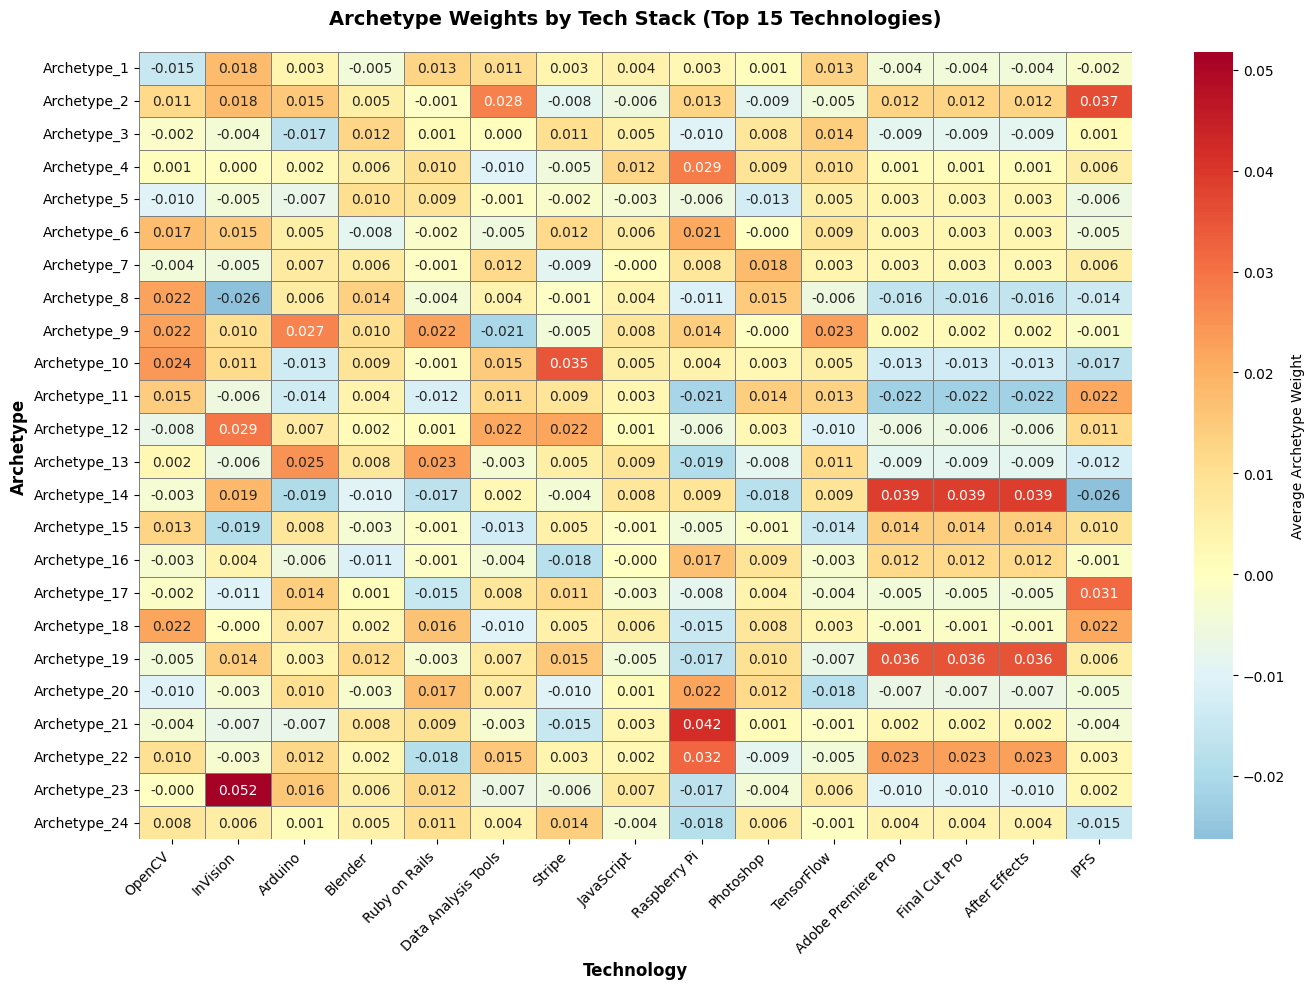

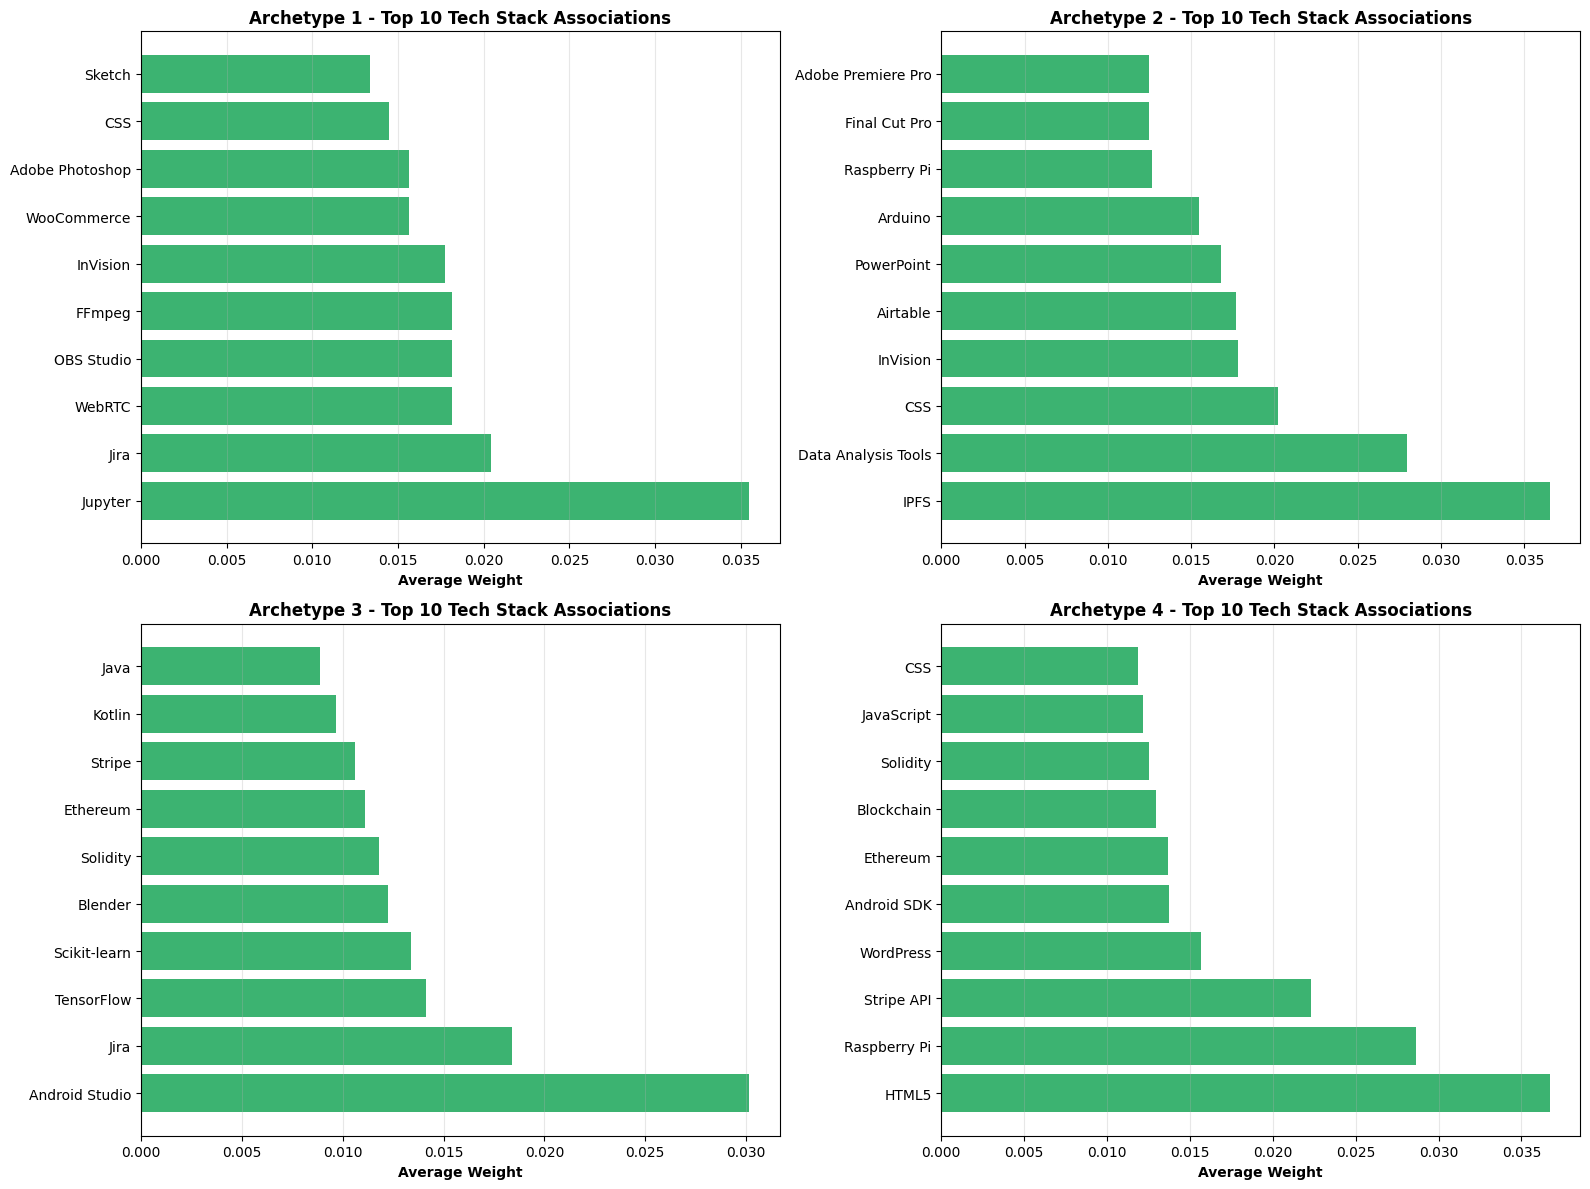


Total number of unique technologies: 75
Showing top 15 technologies in heatmap


In [21]:
# Parse tech_stack and create a mapping
# tech_stack is stored as a list, so we need to expand it
tech_archetype_data = []

for idx, row in founder_archetype_df.iterrows():
    tech_list = row['tech_stack'] if isinstance(row['tech_stack'], list) else ast.literal_eval(str(row['tech_stack']))
    if tech_list:  # Only process if tech_stack is not empty
        for tech in tech_list:
            tech_archetype_data.append({
                'tech': tech,
                **{f'Archetype_{i+1}': row[f'Archetype_{i+1}'] for i in range(best_A)}
            })

tech_archetype_df = pd.DataFrame(tech_archetype_data)

# Calculate average archetype weights by tech stack
tech_archetype = tech_archetype_df.groupby('tech')[[f'Archetype_{i+1}' for i in range(best_A)]].mean()

# Sort by total weight across all archetypes to show most important tech stacks
tech_archetype['total_weight'] = tech_archetype.sum(axis=1)
tech_archetype = tech_archetype.sort_values('total_weight', ascending=False).drop('total_weight', axis=1)

# Show top 15 tech stacks to keep visualization readable
top_techs = tech_archetype.head(15)

# Create heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(top_techs.T,
            annot=True,
            fmt='.3f',
            cmap='RdYlBu_r',
            center=0,
            cbar_kws={'label': 'Average Archetype Weight'},
            linewidths=0.5,
            linecolor='gray')

plt.title('Archetype Weights by Tech Stack (Top 15 Technologies)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Technology', fontsize=12, fontweight='bold')
plt.ylabel('Archetype', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Bar plot for tech stack associations (showing top 10 techs per archetype)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for arch_idx in range(min(best_A, 4)):  # Show first 4 archetypes
    arch_data = tech_archetype[f'Archetype_{arch_idx+1}'].sort_values(ascending=False).head(10)
    axes[arch_idx].barh(range(len(arch_data)), arch_data.values, color='mediumseagreen')
    axes[arch_idx].set_yticks(range(len(arch_data)))
    axes[arch_idx].set_yticklabels(arch_data.index)
    axes[arch_idx].set_xlabel('Average Weight', fontweight='bold')
    axes[arch_idx].set_title(f'Archetype {arch_idx+1} - Top 10 Tech Stack Associations', fontweight='bold')
    axes[arch_idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal number of unique technologies: {len(tech_archetype)}")
print(f"Showing top 15 technologies in heatmap")


## Loop over the founders and store their recommendations

In [22]:
all_recommendations = {}

for i in range(n_founders):
    all_recommendations[founder_ids[i]] = recommend_top_k_for_founder(
        best_model, founder_index=i, k=5
    )

# Example: see recommendations for a particular founder_id
some_id = founder_ids[4]
all_recommendations[some_id]


,founder_id,preferred_role,industry,years_of_experience,is_technical,problem_space,predicted_match_score
0,2edb159ccdf73d8ecab52f59ccf89169,CEO,Fintech,2,False,Many young adults struggle with budgeting and ...,0.033928
1,57e97146f3178893f1d863213a054b98,CTO,Fintech,3,True,Many individuals lack access to credit due to ...,0.029108
2,98b0962513c34cc7308f705eb851ba40,CTO,Healthtech,12,False,Many individuals struggle to maintain their he...,0.028525
3,1843276ca76cfc6be06424333b1c0436,CEO,Edtech,6,True,Many students struggle with traditional learni...,0.027100
4,4e916dcf5ecfaa5999e28488a09a7e1c,CPO,Climate / Greentech,12,True,Urban areas struggle with food sustainability ...,0.026537
